In [47]:
import pandas as pd
import re

In [48]:
df_maiden = pd.read_csv('maiden.csv')
df_ts = pd.read_csv('ts.csv')

In [49]:
df_ts = df_ts.rename(columns={'album_name': 'album', 'track_title': 'title'})

In [50]:
df_maiden['artist'] = 'm'
df_ts['artist'] = 't'

In [51]:
df_geral = pd.concat([df_maiden, df_ts], axis=0).reset_index(drop=True)

In [52]:
num_classes = df_geral['artist'].value_counts()
print(num_classes)

t    163
m    141
Name: artist, dtype: int64


In [53]:
df_geral

,album,title,lyric,artist
0,Somewhere in Time,The Loneliness of the Long Distance Runner,"Can't understand what is happening to me,\nThi...",m
1,Somewhere in Time,Sea of Madness,"Out in the street somebody's crying,\nOut in t...",m
2,Somewhere in Time,Stranger in a Strange Land,Was many years ago that I left home and came t...,m
3,Somewhere in Time,Alexander The Great,"""My son, ask for thyself another kingdom,\nFor...",m
4,Somewhere in Time,Deja Vu,"When you see familiar faces,\nBut you don't re...",m
...,...,...,...,...
299,reputation,King of My Heart,"I'm perfectly fine, I live on my own\nI made u...",t
300,reputation,Look What You Made Me Do,I don't like your little games\nDon't like you...,t
301,reputation,New Year’s Day,There's glitter on the floor after the party\n...,t
302,reputation,So It Goes...,"See you in the dark\nAll eyes on you, my magic...",t


## Pré-processamento

In [54]:
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gibberish_detector import detector

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/mateus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mateus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [55]:
df_geral['lyric'] = df_geral['lyric'].str.lower()

In [56]:
df_geral['or_lyric'] = df_geral['lyric']

In [57]:
df_geral['lyric'] = df_geral['lyric'].str.replace('\n', ' ')

In [58]:
# Removendo contrações
df_geral['lyric'] = df_geral['lyric'].apply(lambda x: contractions.fix(x, slang=True))

In [59]:
# Removendo chaves
df_geral['lyric'] = df_geral['lyric'].apply(lambda x: re.sub(r'\[\w+\]', '', x))

# Removendo parenteses
df_geral['lyric'] = df_geral['lyric'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))

# Removendo pontuação
df_geral['lyric'] = df_geral['lyric'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [60]:
df_geral['lyric'] = df_geral['lyric'].apply(lambda x: ' '.join(x.split()))

In [61]:
stop_words = set(stopwords.words('english'))
new_stop_words = ['oh', 'ooh', 'ooh-ooh', 'hey', 'oh-', 'oh-oh', 'ooh', 'ooh-ooh' 'yeah', 'mmm', 'ah', 'whoa', 'eh', 'chorus', '``']
stop_words.update(new_stop_words)

In [62]:
def remove_stop_words(df):
    df['processed'] = df['lyric'].apply(nltk.word_tokenize)
    df['processed'] = df['processed'].apply(lambda x: [row for row in x if row not in stop_words])
    return df

In [63]:
df_geral = remove_stop_words(df_geral)

In [64]:
df_geral['lyric']

0      cannot understand what is happening to me this...
1      out in the street somebody is crying out in th...
2      was many years ago that i left home and came t...
3      my son ask for thyself another kingdom for tha...
4      when you see familiar faces but you do not rem...
                             ...                        
299    i am perfectly fine i live on my own i made up...
300    i do not like your little games do not like yo...
301    there is glitter on the floor after the party ...
302    see you in the dark all eyes on you my magicia...
303    it was so nice throwing big parties jump into ...
Name: lyric, Length: 304, dtype: object

# Lemmatization

In [19]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mateus/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/mateus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mateus/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [20]:
wnl = WordNetLemmatizer()

In [21]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [22]:
def lemmatize(tokenized):
    return [wnl.lemmatize(w, get_wordnet_pos(w)) for w in tokenized]

In [ ]:
df_geral['lemma'] = df_geral['processed'].apply(lemmatize)

In [24]:
print(f"Processed: {' '.join(df_geral['processed'][1][0:6])}")
print(f"Lemmatization: {' '.join(df_geral['lemma'][1][0:6])}")

Processed: street somebody crying night fires burn
Lemmatization: street somebody cry night fire burn


# Treinando SVC

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [ ]:
df_geral['text'] = df_geral['lemma'].apply(lambda x:' '.join(x))

In [ ]:
y = df_geral['artist']
X = df_geral['text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Vetorização do texto (usando TF-IDF neste exemplo)
vectorizer = TfidfVectorizer(max_features=1000)
X_treino_transformado = vectorizer.fit_transform(X_train)
X_teste_transformado = vectorizer.transform(X_test)

palavras = vectorizer.get_feature_names()

X_treino_df = pd.DataFrame(X_treino_transformado.toarray(), columns=palavras)

relevancia_palavras = X_treino_df.sum(axis=0).sort_values(ascending=False)

top_palavras = relevancia_palavras.head(10)
print("Palavras com maior relevância no corpus:")
print(top_palavras)

In [ ]:
modelo_svm = SVC(kernel='linear', C=1.0)
modelo_svm.fit(X_treino_transformado, y_train)

previsoes = modelo_svm.predict(X_teste_transformado)
relatorio_classificacao = classification_report(y_test, previsoes)
print('Relatório de Classificação:\n', relatorio_classificacao)

Relatório de Classificação:
               precision    recall  f1-score   support

           m       0.93      0.89      0.91        44
           t       0.90      0.94      0.92        48

    accuracy                           0.91        92
   macro avg       0.91      0.91      0.91        92
weighted avg       0.91      0.91      0.91        92



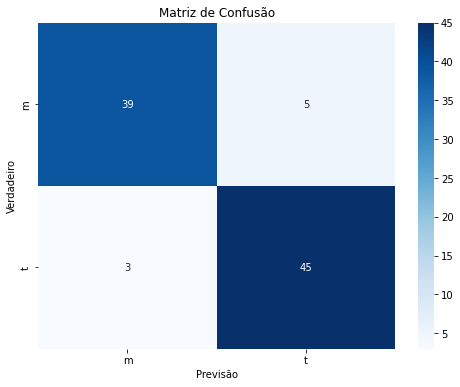

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

matriz_confusao = confusion_matrix(y_test, previsoes)

# Exibir como heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', xticklabels=modelo_svm.classes_, yticklabels=modelo_svm.classes_)
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
resultados_df = pd.DataFrame({
    'indice': range(len(y_test)),  
    'classe': y_test,  
    'predita': previsoes 
})

resultados_df['erro'] = resultados_df['classe'] != resultados_df['predita']

erros_df = resultados_df[resultados_df['erro']]

X_test_df = pd.DataFrame(X_test) if not isinstance(X_test, pd.DataFrame) else X_test

# Adicionar as linhas de X_test aos erros
erros_df['dados'] = X_test_df.iloc[erros_df['indice']].values

print("Erros de Classificação com Dados Originais:")
print(erros_df[['indice', 'dados', 'classe', 'predita']])


Erros de Classificação com Dados Originais:
     indice                                              dados classe predita
180       0  last drop rain dry pavement find stain never w...      t       m
45       12  place dream living seem ship white light sky n...      m       t
176      13  today fairytale prince use damsel distress tak...      t       m
280      35  keep helmet keep life son flesh wound rifle cr...      t       m
92       40  darken sky time prepare salvage last horizon r...      m       t
6        68  time lose open mind time choose would care tak...      m       t
114      75  cold october morning frost lay ground wait mak...      m       t
84       82  let tell story chill bone thing saw one night ...      m       t


/tmp/ipykernel_5063/3348206060.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  erros_df['dados'] = X_test_df.iloc[erros_df['indice']].values


# Análise

In [34]:
print(df_geral['lemma'])

0      [understand, happen, real, dream, never, felt,...
1      [street, somebody, cry, night, fire, burn, may...
2      [many, year, ago, left, home, come, way, young...
3      [son, ask, thyself, another, kingdom, leave, s...
4      [see, familiar, face, remember, could, wrong, ...
                             ...                        
299    [perfectly, fine, live, make, mind, well, bein...
300    [like, little, game, like, tilt, stage, role, ...
301    [glitter, floor, party, girl, carry, shoe, lob...
302    [see, dark, eye, magician, eye, u, make, every...
303    [nice, throw, big, party, jump, pool, balcony,...
Name: lemma, Length: 304, dtype: object


In [35]:
import spacy
import matplotlib.pyplot as plt
nlp = spacy.load('en_core_web_sm')

In [36]:
def get_words(texto, word):
    doc = nlp(texto)
    lista = []
    for token in doc:
        if token.pos_ == word:
            
            if word == 'VERB' and not(token.text == '\'' or token.text == 'm'):
                lista.append(token.text)
            
            elif word == 'NOUN' and not(token.text == '\'' or token.text == 'm'):
                lista.append(token.text)
            
            elif word == 'ADJ' and not(token.text == '\'' or token.text == 'm'):
                lista.append(token.text)
            
            elif word == 'ADV' and not(token.text == '\'' or token.text == 'm'):
                lista.append(token.text)

            lista.append(token.text)
    return lista

In [37]:
df_maiden = df_geral.loc[df_geral['artist'] == 'm']
df_ts = df_geral.loc[df_geral['artist'] == 't']

In [38]:
adj = df_maiden['text'].apply(get_words, word='ADJ')
sub = df_maiden['text'].apply(get_words, word='NOUN')
ver = df_maiden['text'].apply(get_words, word='VERB')
adv = df_maiden['text'].apply(get_words, word='ADV')

count_adj_m = pd.Series([word for sublist in adj for word in sublist]).value_counts()
count_sub_m = pd.Series([word for sublist in sub for word in sublist]).value_counts()
count_ver_m = pd.Series([word for sublist in ver for word in sublist]).value_counts()
count_adv_m = pd.Series([word for sublist in adv for word in sublist]).value_counts()

In [39]:
adj = df_ts['text'].apply(get_words, word='ADJ')
sub = df_ts['text'].apply(get_words, word='NOUN')
ver = df_ts['text'].apply(get_words, word='VERB')
adv = df_ts['text'].apply(get_words, word='ADV')

count_adj_t = pd.Series([word for sublist in adj for word in sublist]).value_counts()
count_sub_t = pd.Series([word for sublist in sub for word in sublist]).value_counts()
count_ver_t = pd.Series([word for sublist in ver for word in sublist]).value_counts()
count_adv_t = pd.Series([word for sublist in adv for word in sublist]).value_counts()

In [40]:
def subplots(sub, adj, ver, adv):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # Plotando os dados em cada subplot
    axs[0, 0].bar(sub[:10].keys(), sub[:10].values)
    axs[0, 0].set_title('Substantivos')
    axs[0, 0].set_xticklabels(sub[:10].keys(), rotation=45)

    axs[0, 1].bar(adj[:10].keys(), adj[:10].values, width=0.7)
    axs[0, 1].set_title('Adjetivos')
    axs[0, 1].set_xticklabels(adj[:10].keys(), rotation=45)

    axs[1, 0].bar(ver[:10].keys(), ver[:10].values)
    axs[1, 0].set_title('Verbos')
    axs[1, 0].set_xticklabels(ver[:10].keys(), rotation=45)

    axs[1, 1].bar(adv[:10].keys(), adv[:10].values)
    axs[1, 1].set_title('Adverbios')
    axs[1, 1].set_xticklabels(adv[:10].keys(), rotation=45)

    # Ajustando o layout
    plt.tight_layout()

    # Mostrando os subplots
    plt.show()

/tmp/ipykernel_90376/1535494244.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels(sub[:10].keys(), rotation=45)
/tmp/ipykernel_90376/1535494244.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels(adj[:10].keys(), rotation=45)
/tmp/ipykernel_90376/1535494244.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 0].set_xticklabels(ver[:10].keys(), rotation=45)
/tmp/ipykernel_90376/1535494244.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(adv[:10].keys(), rotation=45)


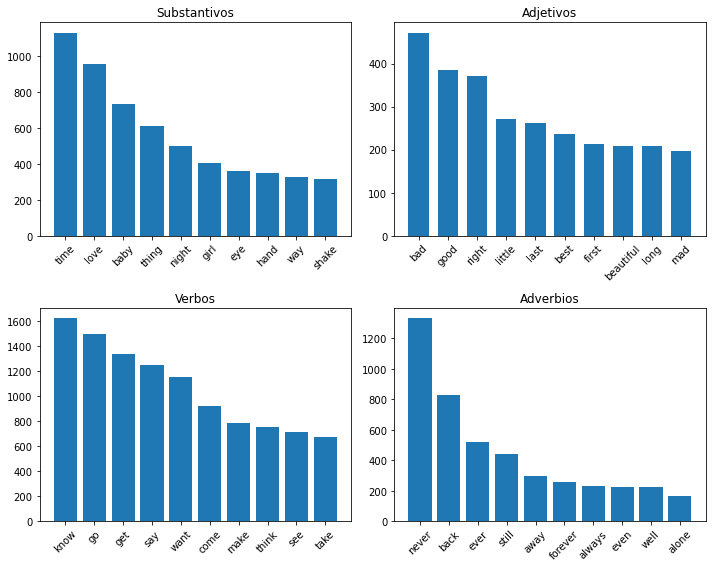

In [41]:
subplots(count_sub_t, count_adj_t,count_ver_t, count_adv_t)

/tmp/ipykernel_90376/1535494244.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels(sub[:10].keys(), rotation=45)
/tmp/ipykernel_90376/1535494244.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels(adj[:10].keys(), rotation=45)
/tmp/ipykernel_90376/1535494244.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 0].set_xticklabels(ver[:10].keys(), rotation=45)
/tmp/ipykernel_90376/1535494244.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(adv[:10].keys(), rotation=45)


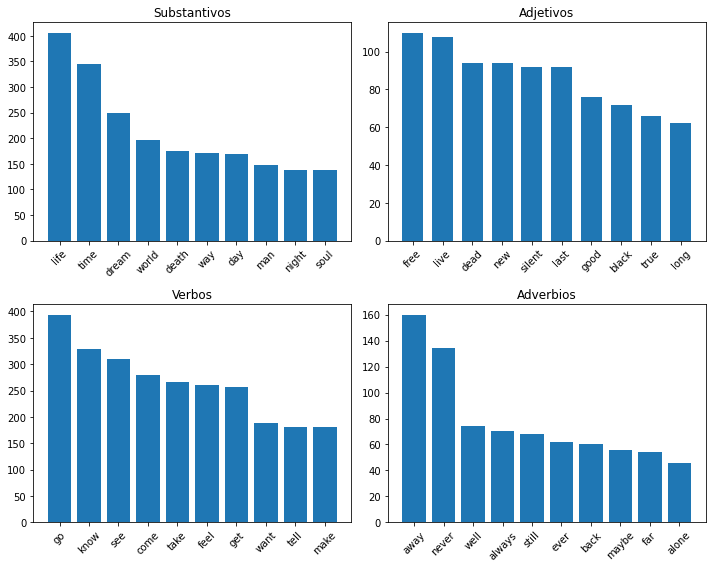

In [42]:
subplots(count_sub_m, count_adj_m,count_ver_m, count_adv_m)

In [43]:
aux_ts = df_geral.drop(columns=['processed'])

In [44]:
aux_ts.to_json('ts.json', orient='records', indent=4)

### Análise sentimento

In [45]:
from transformers import pipeline
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")

In [47]:
def analyze_emotion(lyric):
    phrases = lyric.split('\n')
    
    value_emotion = {
        'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'neutral': 0, 'sadness': 0, 'surprise': 0
    }
    
    count_emotion = {
        'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'neutral': 0, 'sadness': 0, 'surprise': 0
    }
    
    mean_emotion = {
        'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'neutral': 0, 'sadness': 0, 'surprise': 0
    }
    
    for phrase in phrases:
        emotion = classifier(phrase)
        emotion = emotion[0]
        emotion_score = emotion['score']
        emotion_label = emotion['label']
        count_emotion[emotion_label] += 1
        value_emotion[emotion_label] += emotion_score
    
    for key, value in value_emotion.items():
        if value != 0:
            mean_emotion[key] = value / count_emotion[key]
    
    
    return mean_emotion

In [ ]:
df_geral['score_emotion'] = df_geral['or_lyric'].apply(lambda x: analyze_emotion(x))

In [ ]:
#df_geral.to_csv('df_geral.csv', index=False)

In [49]:
from ast import literal_eval

In [50]:
df_geral = pd.read_csv('df_geral.csv')
df_geral['score_emotion'] = df_geral['score_emotion'].apply(literal_eval)

In [51]:
albums_maiden = df_geral.loc[df_geral['artist'] == 'm', 'album'].unique().tolist()
albums_tf = df_geral.loc[df_geral['artist'] == 't', 'album'].unique().tolist()

In [52]:
emotion_album_m = {'album': '', 'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'neutral': 0, 'sadness': 0, 'surprise': 0}
emotion_album_t = {'album': '', 'anger': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'neutral': 0, 'sadness': 0, 'surprise': 0}

In [53]:
def create_columns(df):
    emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
    for emotion in emotions:
        df[emotion] = 0
        
    return df

In [54]:
df_geral = create_columns(df_geral)

In [55]:
def expand_dict(df):
    emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
    for indice, linha in df.iterrows():
        for emotion in emotions:
            df.at[indice, emotion] = linha['score_emotion'][emotion]
    
    
    return df

In [56]:
aux = expand_dict(df_geral)

In [57]:
def mean_album(df, albums):
    # DataFrame auxiliar para armazenar os resultados
    df_aux = pd.DataFrame(columns=['album', 'anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'])

    emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

    for album in albums:
        # Calcula a média de cada emoção para o álbum
        mean_values = {emotion: df.loc[df['album'] == album, emotion].mean() for emotion in emotions}

        # Calcula a soma das médias das emoções para normalização
        total = sum(mean_values.values())

        # Normaliza as emoções para que a soma seja 1
        normalized_values = {emotion: mean_values[emotion] / total for emotion in emotions} if total > 0 else {emotion: 0 for emotion in emotions}

        # Adiciona os valores normalizados ao DataFrame auxiliar
        df_aux = df_aux.append(
            {'album': album, **normalized_values},
            ignore_index=True
        )

    return df_aux


In [ ]:
aux_ts = mean_album(df_geral, albums_tf)

In [ ]:
aux = mean_album(df_geral, albums_maiden)

In [60]:
aux

,album,anger,disgust,fear,joy,neutral,sadness,surprise
0,Somewhere in Time,0.143259,0.061973,0.155086,0.164597,0.155429,0.166833,0.152823
1,Brave New World,0.156258,0.078102,0.154397,0.150638,0.168099,0.171376,0.121130
2,The Book of Souls,0.156154,0.069850,0.171218,0.140202,0.156176,0.183328,0.123072
3,Killers,0.169359,0.043273,0.132520,0.169735,0.157858,0.191826,0.135430
4,Iron maiden,0.160571,0.071049,0.076517,0.196338,0.174710,0.184357,0.136458
5,The X Factor,0.147812,0.075546,0.152456,0.143543,0.145704,0.183389,0.151551
6,Powerslave,0.176320,0.112152,0.161840,0.142201,0.155530,0.145353,0.106605
7,The Final Frontier,0.145918,0.076517,0.152930,0.174267,0.144793,0.171338,0.134238
8,A Matter of Life and Death,0.163334,0.109179,0.145193,0.137513,0.152207,0.165298,0.127276
9,Dance of Death,0.131566,0.087372,0.179032,0.162306,0.150411,0.180389,0.108925


In [61]:
def prepare_to_heat(df, albums):
    data = []
    emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
    
    for album in albums:
        for emotion in emotions:
            # Criar um novo dicionário para cada iteração
            dictionary = {'album': album, 'emotion': emotion, 'score': 0}
            
            # Localizar a linha no DataFrame e atribuir o valor ao dicionário
            line = df.loc[df['album'] == album, emotion]
            dictionary['score'] = line.iloc[0]
            
            # Adicionar o dicionário à lista
            data.append(dictionary)

    # Criar um DataFrame a partir da lista de dicionários
    return pd.DataFrame(data)

In [62]:
df_m = prepare_to_heat(aux, albums_maiden)
df_t = prepare_to_heat(aux_ts, albums_tf)

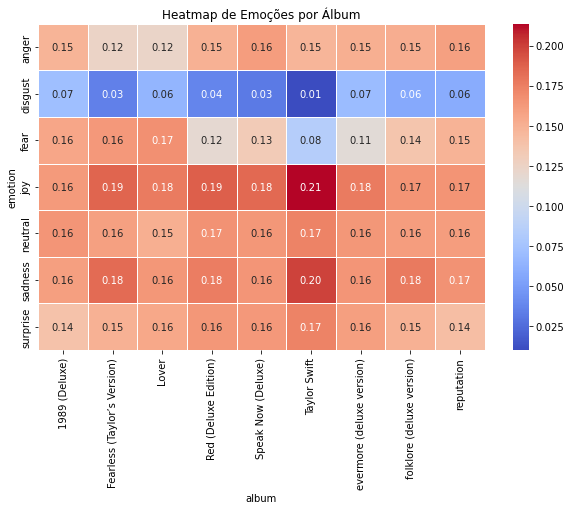

In [63]:
heatmap_data = df_t.pivot(index='emotion', columns='album', values='score')

# Plotar o heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap de Emoções por Álbum')
plt.show()

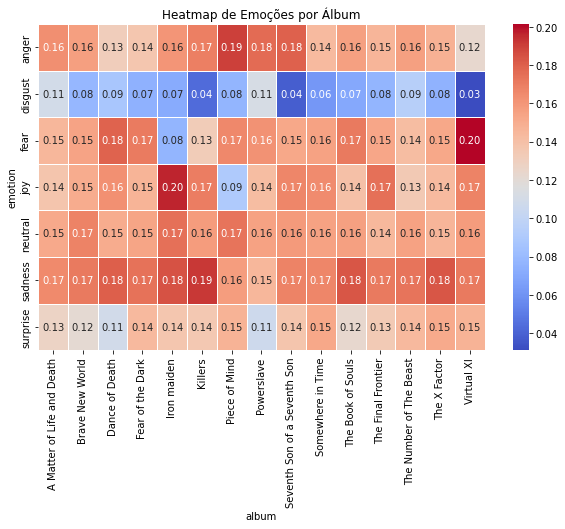

In [64]:
heatmap_data = df_m.pivot(index='emotion', columns='album', values='score')

# Plotar o heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap de Emoções por Álbum')
plt.show()